## Imports

In [1]:
%matplotlib inline
from utils import *
from plotting import *
from models import *

## Load Dataset (e.g., Animal-AI_v3)

In [2]:
dataset, pose = load_dataset('dataset_animalai3', file_format='.npy', load_pose=True, pose_filename='pose.npy')

In [3]:
position = pose[:,:2]
orientation = pose[:,2]

In [4]:
print(dataset.shape, pose.shape)

(20000, 84, 84, 3) (20000, 3)


### Occupancy map

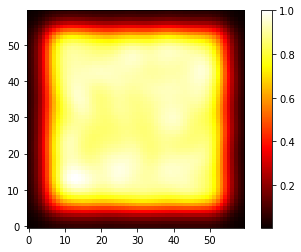

In [5]:
occ_map = occupancy_map(position, filter_width=3, padding=True, n_bins_padding=5)
plt.imshow(occ_map, cmap='hot', origin='lower')
plt.colorbar()

## Autoencoder Grid Search

In [6]:
training_sizes = [500, 1000, 2000, 4000, 8000, 16000]
sparsity_weights = [0, 1e-2, 1e-1, 1, 1e1, 1e2]
n_exp_cond = 2

loss_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))
SI_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))
n_fields_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))
lin_scores_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))
similarity_preserving_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))
population_sparseness_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))
allocentricity_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))
intrinsic_dimensionality_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))

for i, t_size in enumerate(training_sizes):
    print('')
    print('training size: ', t_size)
    for j, s_weight in enumerate(sparsity_weights):
        print('sparsity weight: ', s_weight)
        for z in range(n_exp_cond):
            model = Conv_AE(n_hidden=200)
            
            indxs_data = np.random.choice(np.arange(dataset.shape[0]), size=t_size, replace=False)
            dataset_reduced = dataset[indxs_data, :]
            position_reduced = position[indxs_data, :]
            orientation_reduced = orientation[indxs_data]
            
            train_loader = create_dataloader(dataset_reduced, batch_size=64)
            
            history = train_autoencoder(model, train_loader, num_epochs=500, learning_rate=1e-4, 
                                        L2_weight_decay=0, L1_lambda=0, orth_alpha=s_weight, soft_sparsity_weight=0)
            
            loss_gridsearch[i,j,z] = history[-1]
            
            embeddings = get_latent_vectors(dataset_reduced, model)
            
            all_ratemaps = ratemaps(embeddings, position, n_bins=50, filter_width=3, occupancy_map=[], padding=True, n_bins_padding=5)
            
            SI = spatial_information(all_ratemaps, occ_map)
            SI_gridsearch[i,j,z] = np.mean(SI[np.nonzero(SI)])
            
            n_fields, centroids, sizes = stats_place_fields(all_ratemaps)
            n_fields_gridsearch[i,j,z] = np.mean(n_fields)
            
            lin_score, baseline_score, ratio = linear_decoding_score(embeddings, position_reduced, n_baseline=100)
            lin_scores_gridsearch[i,j,z] = lin_score
            
            sim_pres_score, slope = input_output_similarity(dataset_reduced, embeddings, N=1e5)
            similarity_preserving_gridsearch[i,j,z] = sim_pres_score
            
            pop_sparse_score = population_sparseness(all_ratemaps, active_threshold=0.2)
            population_sparseness_gridsearch[i,j,z] = pop_sparse_score
            
            allo_score = allocentricity(embeddings, orientation_reduced, n_bins=20)
            allocentricity_gridsearch[i,j,z] = allo_score
            
            in_dim = intrinsic_dimensionality(embeddings, method='PCA')
            intrinsic_dimensionality_gridsearch[i,j,z] = in_dim


training size:  500
sparsity weight:  0


Epoch 136/500, Loss: 0.0100: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.21it/s]


Epoch 272/500, Loss: 0.0074: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.51it/s]


Epoch 408/500, Loss: 0.0061: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.36it/s]


Epoch 44/500, Loss: 0.0197: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.84it/s]


Epoch 180/500, Loss: 0.0100: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.80it/s]


Epoch 316/500, Loss: 0.0078: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.20it/s]


Epoch 452/500, Loss: 0.0067: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.38it/s]


Epoch 500/500, Loss: 0.0064: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.46it/s]


sparsity weight:  0.01


Epoch 136/500, Loss: 0.0146: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 43.83it/s]


Epoch 272/500, Loss: 0.0108: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.61it/s]


Epoch 408/500, Loss: 0.0095: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.61it/s]


Epoch 44/500, Loss: 0.0282: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.20it/s]


Epoch 180/500, Loss: 0.0132: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.21it/s]


Epoch 316/500, Loss: 0.0113: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.32it/s]


Epoch 452/500, Loss: 0.0102: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.32it/s]


Epoch 500/500, Loss: 0.0098: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.32it/s]


sparsity weight:  0.1


Epoch 136/500, Loss: 0.0143: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.21it/s]


Epoch 272/500, Loss: 0.0110: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.62it/s]


Epoch 408/500, Loss: 0.0102: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.11it/s]


Epoch 44/500, Loss: 0.0288: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.56it/s]


Epoch 180/500, Loss: 0.0136: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.32it/s]


Epoch 316/500, Loss: 0.0123: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.56it/s]


Epoch 452/500, Loss: 0.0113: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.07it/s]


Epoch 500/500, Loss: 0.0109: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.07it/s]


sparsity weight:  1


Epoch 136/500, Loss: 0.0155: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.33it/s]


Epoch 272/500, Loss: 0.0126: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.60it/s]


Epoch 408/500, Loss: 0.0123: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.03it/s]


Epoch 44/500, Loss: 0.0301: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.06it/s]


Epoch 180/500, Loss: 0.0164: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.10it/s]


Epoch 316/500, Loss: 0.0146: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.81it/s]


Epoch 452/500, Loss: 0.0139: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.90it/s]


Epoch 500/500, Loss: 0.0134: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 43.59it/s]


sparsity weight:  10.0


Epoch 136/500, Loss: 0.0174: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.91it/s]


Epoch 272/500, Loss: 0.0145: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.32it/s]


Epoch 408/500, Loss: 0.0140: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.32it/s]


Epoch 44/500, Loss: 0.0295: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.83it/s]


Epoch 180/500, Loss: 0.0133: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.61it/s]


Epoch 316/500, Loss: 0.0120: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.61it/s]


Epoch 452/500, Loss: 0.0114: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.74it/s]


Epoch 500/500, Loss: 0.0114: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.03it/s]


sparsity weight:  100.0


Epoch 136/500, Loss: 0.0149: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.32it/s]


Epoch 272/500, Loss: 0.0136: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.31it/s]


Epoch 408/500, Loss: 0.0131: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.75it/s]


Epoch 44/500, Loss: 0.0305: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.21it/s]


Epoch 180/500, Loss: 0.0150: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.62it/s]


Epoch 316/500, Loss: 0.0132: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.61it/s]


Epoch 452/500, Loss: 0.0125: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.18it/s]


Epoch 500/500, Loss: 0.0124: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.32it/s]



training size:  1000
sparsity weight:  0


Epoch 136/500, Loss: 0.0085: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 48.04it/s]


Epoch 272/500, Loss: 0.0063: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.24it/s]


Epoch 408/500, Loss: 0.0052: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 48.04it/s]


Epoch 44/500, Loss: 0.0122: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 49.06it/s]


Epoch 180/500, Loss: 0.0073: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.88it/s]


Epoch 316/500, Loss: 0.0058: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.33it/s]


Epoch 452/500, Loss: 0.0050: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.74it/s]


Epoch 500/500, Loss: 0.0048: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.60it/s]


sparsity weight:  0.01


Epoch 136/500, Loss: 0.0124: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.60it/s]


Epoch 272/500, Loss: 0.0105: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.75it/s]


Epoch 408/500, Loss: 0.0093: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.32it/s]


Epoch 44/500, Loss: 0.0193: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 48.61it/s]


Epoch 180/500, Loss: 0.0115: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.36it/s]


Epoch 316/500, Loss: 0.0097: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.19it/s]


Epoch 452/500, Loss: 0.0081: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.19it/s]


Epoch 500/500, Loss: 0.0077: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.46it/s]


sparsity weight:  0.1


Epoch 136/500, Loss: 0.0128: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 48.18it/s]


Epoch 272/500, Loss: 0.0112: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.46it/s]


Epoch 408/500, Loss: 0.0101: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.18it/s]


Epoch 44/500, Loss: 0.0204: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 49.06it/s]


Epoch 180/500, Loss: 0.0141: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.61it/s]


Epoch 316/500, Loss: 0.0126: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.60it/s]


Epoch 452/500, Loss: 0.0110: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.18it/s]


Epoch 500/500, Loss: 0.0104: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.89it/s]


sparsity weight:  1


Epoch 136/500, Loss: 0.0137: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 48.33it/s]


Epoch 272/500, Loss: 0.0125: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.32it/s]


Epoch 408/500, Loss: 0.0118: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.46it/s]


Epoch 44/500, Loss: 0.0190: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 48.77it/s]


Epoch 180/500, Loss: 0.0125: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.19it/s]


Epoch 316/500, Loss: 0.0117: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.91it/s]


Epoch 452/500, Loss: 0.0111: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.19it/s]


Epoch 500/500, Loss: 0.0109: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.91it/s]


sparsity weight:  10.0


Epoch 136/500, Loss: 0.0130: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 48.18it/s]


Epoch 272/500, Loss: 0.0120: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.60it/s]


Epoch 408/500, Loss: 0.0112: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.32it/s]


Epoch 44/500, Loss: 0.0207: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 48.18it/s]


Epoch 180/500, Loss: 0.0141: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.32it/s]


Epoch 316/500, Loss: 0.0129: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.60it/s]


Epoch 452/500, Loss: 0.0121: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.63it/s]


Epoch 500/500, Loss: 0.0119: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.32it/s]


sparsity weight:  100.0


Epoch 136/500, Loss: 0.0123: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 48.03it/s]


Epoch 272/500, Loss: 0.0114: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.60it/s]


Epoch 408/500, Loss: 0.0111: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.32it/s]


Epoch 44/500, Loss: 0.0198: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 48.32it/s]


Epoch 180/500, Loss: 0.0140: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.89it/s]


Epoch 316/500, Loss: 0.0132: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.32it/s]


Epoch 452/500, Loss: 0.0127: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.18it/s]


Epoch 500/500, Loss: 0.0127: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.18it/s]



training size:  2000
sparsity weight:  0


Epoch 136/500, Loss: 0.0067: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.50it/s]


Epoch 272/500, Loss: 0.0051: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.32it/s]


Epoch 408/500, Loss: 0.0044: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.44it/s]


Epoch 44/500, Loss: 0.0097: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.61it/s]


Epoch 180/500, Loss: 0.0058: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.04it/s]


Epoch 316/500, Loss: 0.0046: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.25it/s]


Epoch 452/500, Loss: 0.0040: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.77it/s]


Epoch 500/500, Loss: 0.0039: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.33it/s]


sparsity weight:  0.01


Epoch 136/500, Loss: 0.0103: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.32it/s]


Epoch 272/500, Loss: 0.0080: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.32it/s]


Epoch 408/500, Loss: 0.0068: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.05it/s]


Epoch 44/500, Loss: 0.0149: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 49.82it/s]


Epoch 180/500, Loss: 0.0107: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.32it/s]


Epoch 316/500, Loss: 0.0092: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.76it/s]


Epoch 452/500, Loss: 0.0077: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.82it/s]


Epoch 500/500, Loss: 0.0074: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.47it/s]


sparsity weight:  0.1


Epoch 136/500, Loss: 0.0125: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.22it/s]


Epoch 272/500, Loss: 0.0104: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.03it/s]


Epoch 408/500, Loss: 0.0091: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.70it/s]


Epoch 44/500, Loss: 0.0148: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.32it/s]


Epoch 180/500, Loss: 0.0120: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 37.22it/s]


Epoch 316/500, Loss: 0.0100: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.10it/s]


Epoch 452/500, Loss: 0.0087: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.30it/s]


Epoch 500/500, Loss: 0.0085: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.43it/s]


sparsity weight:  1


Epoch 136/500, Loss: 0.0132: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.25it/s]


Epoch 272/500, Loss: 0.0116: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.98it/s]


Epoch 408/500, Loss: 0.0106: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.91it/s]


Epoch 44/500, Loss: 0.0171: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 49.67it/s]


Epoch 180/500, Loss: 0.0130: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.38it/s]


Epoch 316/500, Loss: 0.0117: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.77it/s]


Epoch 452/500, Loss: 0.0107: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.98it/s]


Epoch 500/500, Loss: 0.0103: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.50it/s]


sparsity weight:  10.0


Epoch 136/500, Loss: 0.0125: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.53it/s]


Epoch 272/500, Loss: 0.0113: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.91it/s]


Epoch 408/500, Loss: 0.0106: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.12it/s]


Epoch 44/500, Loss: 0.0148: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.25it/s]


Epoch 180/500, Loss: 0.0117: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.12it/s]


Epoch 316/500, Loss: 0.0109: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.91it/s]


Epoch 452/500, Loss: 0.0104: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.05it/s]


Epoch 500/500, Loss: 0.0103: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.18it/s]


sparsity weight:  100.0


Epoch 136/500, Loss: 0.0141: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.18it/s]


Epoch 272/500, Loss: 0.0122: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.91it/s]


Epoch 408/500, Loss: 0.0114: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.84it/s]


Epoch 44/500, Loss: 0.0151: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.39it/s]


Epoch 180/500, Loss: 0.0125: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.03it/s]


Epoch 316/500, Loss: 0.0116: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.98it/s]


Epoch 452/500, Loss: 0.0109: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.98it/s]


Epoch 500/500, Loss: 0.0110: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.98it/s]



training size:  4000
sparsity weight:  0


Epoch 136/500, Loss: 0.0056: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.45it/s]


Epoch 272/500, Loss: 0.0044: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.48it/s]


Epoch 408/500, Loss: 0.0039: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.41it/s]


Epoch 44/500, Loss: 0.0083: 100%|██████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.64it/s]


Epoch 180/500, Loss: 0.0050: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.65it/s]


Epoch 316/500, Loss: 0.0041: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 42.51it/s]


Epoch 452/500, Loss: 0.0037: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.96it/s]


Epoch 500/500, Loss: 0.0036: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.10it/s]


sparsity weight:  0.01


Epoch 136/500, Loss: 0.0091: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.28it/s]


Epoch 272/500, Loss: 0.0072: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.93it/s]


Epoch 408/500, Loss: 0.0063: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.69it/s]


Epoch 44/500, Loss: 0.0118: 100%|██████████████████████████████████████████████████████| 63/63 [00:01<00:00, 48.04it/s]


Epoch 180/500, Loss: 0.0081: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.86it/s]


Epoch 316/500, Loss: 0.0069: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.96it/s]


Epoch 452/500, Loss: 0.0063: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.41it/s]


Epoch 500/500, Loss: 0.0061: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.00it/s]


sparsity weight:  0.1


Epoch 136/500, Loss: 0.0110: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.14it/s]


Epoch 272/500, Loss: 0.0089: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.55it/s]


Epoch 408/500, Loss: 0.0079: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.89it/s]


Epoch 44/500, Loss: 0.0134: 100%|██████████████████████████████████████████████████████| 63/63 [00:01<00:00, 48.04it/s]


Epoch 180/500, Loss: 0.0103: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.93it/s]


Epoch 316/500, Loss: 0.0090: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.62it/s]


Epoch 452/500, Loss: 0.0081: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.96it/s]


Epoch 500/500, Loss: 0.0078: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.21it/s]


sparsity weight:  1


Epoch 136/500, Loss: 0.0124: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.07it/s]


Epoch 272/500, Loss: 0.0108: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.38it/s]


Epoch 408/500, Loss: 0.0102: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.41it/s]


Epoch 44/500, Loss: 0.0138: 100%|██████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.78it/s]


Epoch 180/500, Loss: 0.0111: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.89it/s]


Epoch 316/500, Loss: 0.0101: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.69it/s]


Epoch 452/500, Loss: 0.0095: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.64it/s]


Epoch 500/500, Loss: 0.0092: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.17it/s]


sparsity weight:  10.0


Epoch 136/500, Loss: 0.0122: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 45.18it/s]


Epoch 272/500, Loss: 0.0111: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.07it/s]


Epoch 408/500, Loss: 0.0104: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.11it/s]


Epoch 44/500, Loss: 0.0131: 100%|██████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.32it/s]


Epoch 180/500, Loss: 0.0111: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.38it/s]


Epoch 316/500, Loss: 0.0104: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.18it/s]


Epoch 452/500, Loss: 0.0100: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.14it/s]


Epoch 500/500, Loss: 0.0099: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 45.35it/s]


sparsity weight:  100.0


Epoch 136/500, Loss: 0.0119: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.41it/s]


Epoch 272/500, Loss: 0.0105: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.04it/s]


Epoch 408/500, Loss: 0.0098: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 45.97it/s]


Epoch 44/500, Loss: 0.0144: 100%|██████████████████████████████████████████████████████| 63/63 [00:01<00:00, 47.14it/s]


Epoch 180/500, Loss: 0.0118: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.21it/s]


Epoch 316/500, Loss: 0.0108: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.04it/s]


Epoch 452/500, Loss: 0.0103: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.07it/s]


Epoch 500/500, Loss: 0.0101: 100%|█████████████████████████████████████████████████████| 63/63 [00:01<00:00, 45.84it/s]



training size:  8000
sparsity weight:  0


Epoch 136/500, Loss: 0.0044: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 44.84it/s]


Epoch 272/500, Loss: 0.0036: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.61it/s]


Epoch 408/500, Loss: 0.0033: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.61it/s]


Epoch 44/500, Loss: 0.0065: 100%|████████████████████████████████████████████████████| 125/125 [00:02<00:00, 46.99it/s]


Epoch 180/500, Loss: 0.0042: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.93it/s]


Epoch 316/500, Loss: 0.0036: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.59it/s]


Epoch 452/500, Loss: 0.0033: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.68it/s]


Epoch 500/500, Loss: 0.0032: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.63it/s]


sparsity weight:  0.01


Epoch 136/500, Loss: 0.0078: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.96it/s]


Epoch 272/500, Loss: 0.0065: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.44it/s]


Epoch 408/500, Loss: 0.0058: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.21it/s]


Epoch 44/500, Loss: 0.0109: 100%|████████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.19it/s]


Epoch 180/500, Loss: 0.0073: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 46.06it/s]


Epoch 316/500, Loss: 0.0063: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 46.77it/s]


Epoch 452/500, Loss: 0.0059: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.17it/s]


Epoch 500/500, Loss: 0.0057: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 46.56it/s]


sparsity weight:  0.1


Epoch 136/500, Loss: 0.0100: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 46.91it/s]


Epoch 272/500, Loss: 0.0086: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.55it/s]


Epoch 408/500, Loss: 0.0078: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.35it/s]


Epoch 44/500, Loss: 0.0125: 100%|████████████████████████████████████████████████████| 125/125 [00:02<00:00, 48.45it/s]


Epoch 180/500, Loss: 0.0092: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.71it/s]


Epoch 316/500, Loss: 0.0082: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.69it/s]


Epoch 452/500, Loss: 0.0076: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.60it/s]


Epoch 500/500, Loss: 0.0074: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.87it/s]


sparsity weight:  1


Epoch 136/500, Loss: 0.0108: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.80it/s]


Epoch 272/500, Loss: 0.0101: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.75it/s]


Epoch 408/500, Loss: 0.0094: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.76it/s]


Epoch 44/500, Loss: 0.0132: 100%|████████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.19it/s]


Epoch 180/500, Loss: 0.0105: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.73it/s]


Epoch 316/500, Loss: 0.0097: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.75it/s]


Epoch 452/500, Loss: 0.0092: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.71it/s]


Epoch 500/500, Loss: 0.0091: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 46.40it/s]


sparsity weight:  10.0


Epoch 136/500, Loss: 0.0109: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.95it/s]


Epoch 272/500, Loss: 0.0102: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.51it/s]


Epoch 408/500, Loss: 0.0098: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 46.47it/s]


Epoch 44/500, Loss: 0.0135: 100%|████████████████████████████████████████████████████| 125/125 [00:02<00:00, 48.17it/s]


Epoch 180/500, Loss: 0.0106: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.84it/s]


Epoch 316/500, Loss: 0.0100: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.86it/s]


Epoch 452/500, Loss: 0.0097: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.78it/s]


Epoch 500/500, Loss: 0.0094: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.87it/s]


sparsity weight:  100.0


Epoch 136/500, Loss: 0.0108: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.31it/s]


Epoch 272/500, Loss: 0.0100: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.26it/s]


Epoch 408/500, Loss: 0.0097: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.80it/s]


Epoch 44/500, Loss: 0.0127: 100%|████████████████████████████████████████████████████| 125/125 [00:02<00:00, 48.58it/s]


Epoch 180/500, Loss: 0.0105: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.93it/s]


Epoch 316/500, Loss: 0.0101: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.93it/s]


Epoch 452/500, Loss: 0.0099: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.95it/s]


Epoch 500/500, Loss: 0.0098: 100%|███████████████████████████████████████████████████| 125/125 [00:02<00:00, 47.97it/s]



training size:  16000
sparsity weight:  0


Epoch 136/500, Loss: 0.0034: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.86it/s]


Epoch 272/500, Loss: 0.0029: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.81it/s]


Epoch 408/500, Loss: 0.0027: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.91it/s]


Epoch 44/500, Loss: 0.0050: 100%|████████████████████████████████████████████████████| 250/250 [00:05<00:00, 48.30it/s]


Epoch 180/500, Loss: 0.0033: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.71it/s]


Epoch 316/500, Loss: 0.0030: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.22it/s]


Epoch 452/500, Loss: 0.0028: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.92it/s]


Epoch 500/500, Loss: 0.0028: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 48.02it/s]


sparsity weight:  0.01


Epoch 136/500, Loss: 0.0065: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 46.78it/s]


Epoch 272/500, Loss: 0.0055: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 48.01it/s]


Epoch 408/500, Loss: 0.0051: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.94it/s]


Epoch 44/500, Loss: 0.0092: 100%|████████████████████████████████████████████████████| 250/250 [00:05<00:00, 48.45it/s]


Epoch 180/500, Loss: 0.0064: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 48.02it/s]


Epoch 316/500, Loss: 0.0056: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 48.03it/s]


Epoch 452/500, Loss: 0.0052: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.94it/s]


Epoch 500/500, Loss: 0.0051: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.98it/s]


sparsity weight:  0.1


Epoch 136/500, Loss: 0.0094: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.92it/s]


Epoch 272/500, Loss: 0.0081: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.86it/s]


Epoch 408/500, Loss: 0.0075: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.92it/s]


Epoch 44/500, Loss: 0.0104: 100%|████████████████████████████████████████████████████| 250/250 [00:05<00:00, 48.28it/s]


Epoch 180/500, Loss: 0.0082: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.94it/s]


Epoch 316/500, Loss: 0.0073: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.83it/s]


Epoch 452/500, Loss: 0.0068: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 43.86it/s]


Epoch 500/500, Loss: 0.0067: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 46.85it/s]


sparsity weight:  1


Epoch 136/500, Loss: 0.0094: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 46.78it/s]


Epoch 272/500, Loss: 0.0086: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.84it/s]


Epoch 408/500, Loss: 0.0082: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.92it/s]


Epoch 44/500, Loss: 0.0114: 100%|████████████████████████████████████████████████████| 250/250 [00:05<00:00, 48.02it/s]


Epoch 180/500, Loss: 0.0096: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.67it/s]


Epoch 316/500, Loss: 0.0089: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.86it/s]


Epoch 452/500, Loss: 0.0085: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.72it/s]


Epoch 500/500, Loss: 0.0084: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.59it/s]


sparsity weight:  10.0


Epoch 136/500, Loss: 0.0101: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.85it/s]


Epoch 272/500, Loss: 0.0095: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.78it/s]


Epoch 408/500, Loss: 0.0091: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.67it/s]


Epoch 44/500, Loss: 0.0110: 100%|████████████████████████████████████████████████████| 250/250 [00:05<00:00, 48.45it/s]


Epoch 180/500, Loss: 0.0094: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.72it/s]


Epoch 316/500, Loss: 0.0090: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.74it/s]


Epoch 452/500, Loss: 0.0087: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.56it/s]


Epoch 500/500, Loss: 0.0086: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 45.62it/s]


sparsity weight:  100.0


Epoch 136/500, Loss: 0.0106: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.70it/s]


Epoch 272/500, Loss: 0.0100: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.78it/s]


Epoch 408/500, Loss: 0.0097: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.74it/s]


Epoch 44/500, Loss: 0.0120: 100%|████████████████████████████████████████████████████| 250/250 [00:05<00:00, 48.04it/s]


Epoch 180/500, Loss: 0.0101: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.60it/s]


Epoch 316/500, Loss: 0.0095: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.60it/s]


Epoch 452/500, Loss: 0.0092: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.47it/s]


Epoch 500/500, Loss: 0.0091: 100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.60it/s]


In [7]:
loss_gridsearch_avg = np.nanmean(loss_gridsearch, axis=2)
SI_gridsearch_avg = np.nanmean(SI_gridsearch, axis=2)
n_fields_gridsearch_avg = np.nanmean(n_fields_gridsearch, axis=2)
lin_scores_gridsearch_avg = np.nanmean(lin_scores_gridsearch, axis=2)
similarity_preserving_gridsearch_avg = np.nanmean(similarity_preserving_gridsearch, axis=2)
population_sparseness_gridsearch_avg = np.nanmean(population_sparseness_gridsearch, axis=2)
allocentricity_gridsearch_avg = np.nanmean(allocentricity_gridsearch, axis=2)
intrinsic_dimensionality_gridsearch_avg = np.nanmean(intrinsic_dimensionality_gridsearch, axis=2)

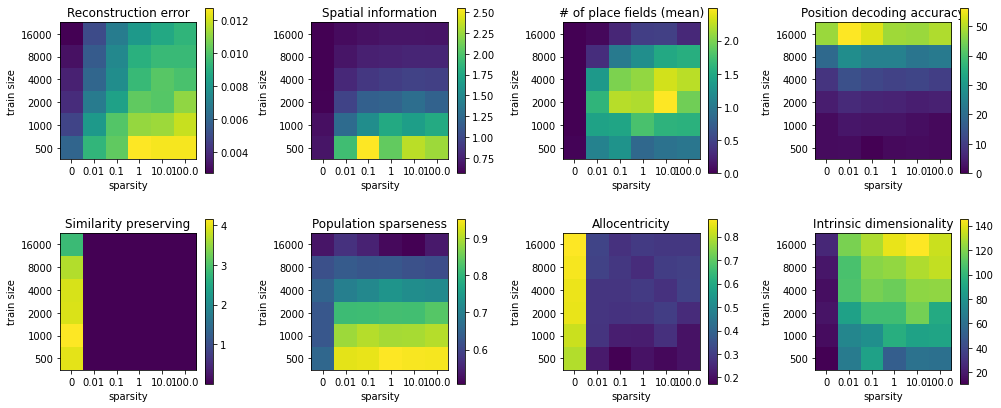

In [30]:
plt.figure(figsize=(14,6))

plt.subplot(241)
plt.imshow(loss_gridsearch_avg, origin='lower')
plt.title('Reconstruction error')
plt.ylabel('train size')
plt.xlabel('sparsity')
plt.yticks(np.arange(len(training_sizes)), training_sizes)
plt.xticks(np.arange(len(sparsity_weights)), sparsity_weights)
plt.colorbar()

plt.subplot(242)
plt.imshow(SI_gridsearch_avg, origin='lower')
plt.title('Spatial information')
plt.ylabel('train size')
plt.xlabel('sparsity')
plt.yticks(np.arange(len(training_sizes)), training_sizes)
plt.xticks(np.arange(len(sparsity_weights)), sparsity_weights)
plt.colorbar()

plt.subplot(243)
plt.imshow(n_fields_gridsearch_avg, origin='lower')
plt.title('# of place fields (mean)')
plt.ylabel('train size')
plt.xlabel('sparsity')
plt.yticks(np.arange(len(training_sizes)), training_sizes)
plt.xticks(np.arange(len(sparsity_weights)), sparsity_weights)
plt.colorbar()

plt.subplot(244)
plt.imshow(lin_scores_gridsearch_avg, origin='lower')
plt.title('Position decoding accuracy')
plt.ylabel('train size')
plt.xlabel('sparsity')
plt.yticks(np.arange(len(training_sizes)), training_sizes)
plt.xticks(np.arange(len(sparsity_weights)), sparsity_weights)
plt.colorbar()

plt.subplot(245)
plt.imshow(similarity_preserving_gridsearch_avg, origin='lower')
plt.title('Similarity preserving')
plt.ylabel('train size')
plt.xlabel('sparsity')
plt.yticks(np.arange(len(training_sizes)), training_sizes)
plt.xticks(np.arange(len(sparsity_weights)), sparsity_weights)
plt.colorbar()

plt.subplot(246)
plt.imshow(population_sparseness_gridsearch_avg, origin='lower')
plt.title('Population sparseness')
plt.ylabel('train size')
plt.xlabel('sparsity')
plt.yticks(np.arange(len(training_sizes)), training_sizes)
plt.xticks(np.arange(len(sparsity_weights)), sparsity_weights)
plt.colorbar()

plt.subplot(247)
plt.imshow(allocentricity_gridsearch_avg, origin='lower')
plt.title('Allocentricity')
plt.ylabel('train size')
plt.xlabel('sparsity')
plt.yticks(np.arange(len(training_sizes)), training_sizes)
plt.xticks(np.arange(len(sparsity_weights)), sparsity_weights)
plt.colorbar()

plt.subplot(248)
plt.imshow(intrinsic_dimensionality_gridsearch_avg, origin='lower')
plt.title('Intrinsic dimensionality')
plt.ylabel('train size')
plt.xlabel('sparsity')
plt.yticks(np.arange(len(training_sizes)), training_sizes)
plt.xticks(np.arange(len(sparsity_weights)), sparsity_weights)
plt.colorbar()

plt.tight_layout()

plt.savefig('grid_search.jpg', dpi=600)
plt.show()